In [1]:
import torch
import pandas as pd
from sklearn import metrics
from scipy.io import loadmat
from os.path import exists
from tqdm import tqdm
import time
import scipy
import os
import matplotlib.colors as mcolors 
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload

# locals 
import sagnn_utils as sag
from HyperSAGNN import HyperSAGNN


sys.path.append("../")
import utils as ut
import plotting as plt2

In [2]:
# break

In [3]:
dpath = "/scratch/indikar_root/indikar1/shared_data/population_pore_c/align_table/"

df = []
for f in os.listdir(dpath):
    if not 'parquet' in f:
        continue

    fpath = f"{dpath}{f}"
    tmp = pd.read_parquet(fpath)
    print(f, tmp.shape)
    df.append(tmp)

df = pd.concat(df)
print(f"{df.shape=}")
df.head()

batch04.GRCm39.align_table.parquet (8434829, 16)
batch02.GRCm39.align_table.parquet (907344, 16)
batch03.GRCm39.align_table.parquet (4579554, 16)
batch01.GRCm39.align_table.parquet (7508851, 16)
df.shape=(21430578, 16)


,read_name,read_start,read_end,monomer_length,chrom,ref_start,ref_end,fragment_id,fragment_start,fragment_end,is_duplicate,is_mapped,is_close,read_unique,read_group,mapping_quality
0,00000202-49cf-47b2-83bf-5eb3f6d98373,0,460,460,10,79553913,79554361.0,10:369876,79553685.0,79554367.0,False,True,False,True,1025705.0,60
1,00000202-49cf-47b2-83bf-5eb3f6d98373,460,687,227,10,79553679,79553895.0,10:369876,79553685.0,79554367.0,False,True,True,True,1025705.0,35
2,00000202-49cf-47b2-83bf-5eb3f6d98373,687,853,166,10,79553496,79553677.0,10:369875,79553502.0,79553685.0,False,True,True,True,1025705.0,26
3,00000202-49cf-47b2-83bf-5eb3f6d98373,853,1490,637,10,79552809,79553496.0,10:369874,79552815.0,79553502.0,False,True,True,True,1025705.0,60
4,00000202-49cf-47b2-83bf-5eb3f6d98373,1490,1714,224,None,-1,NaN,None,NaN,NaN,False,False,False,True,1025705.0,0


In [4]:
def filter_and_prepare_data(df, resolution, mapq=60):
    """Filters and prepares contact data for analysis.

    Args:
        df (pd.DataFrame): The raw DataFrame containing contact data.
        resolution (int): The desired genomic resolution for binning.
        mapq (int, optional): The minimum mapping quality to filter by. Defaults to 60.

    Returns:
        pd.DataFrame: The filtered and processed DataFrame.
    """
    # Filtering
    filtered_df = df[df['mapping_quality'] >= mapq].copy()  # Filter by MAPQ
    filtered_df = filtered_df[filtered_df['fragment_id'].notna()] 

    # Binning
    filtered_df['bin'] = filtered_df['ref_start'].apply(lambda x: ut.bin_loci(x, resolution))
    return filtered_df  

resolution = 1000000
# resolution = 100000
mapq = 60
# mapq = 1
resolution_str = ut.human_readable_bp(resolution)  
print(f"Binning at {resolution_str} with mapq == {mapq}")
pdf = filter_and_prepare_data(df, resolution, mapq=mapq)
print(f"{pdf.shape=}")
pdf.head()

Binning at 1Mb with mapq == 60
pdf.shape=(9934765, 17)


,read_name,read_start,read_end,monomer_length,chrom,ref_start,ref_end,fragment_id,fragment_start,fragment_end,is_duplicate,is_mapped,is_close,read_unique,read_group,mapping_quality,bin
0,00000202-49cf-47b2-83bf-5eb3f6d98373,0,460,460,10,79553913,79554361.0,10:369876,79553685.0,79554367.0,False,True,False,True,1025705.0,60,80.0
3,00000202-49cf-47b2-83bf-5eb3f6d98373,853,1490,637,10,79552809,79553496.0,10:369874,79552815.0,79553502.0,False,True,True,True,1025705.0,60,80.0
6,0000131a-4f27-4dc5-839d-09720b024db9,0,236,236,4,45374671,45374875.0,4:195912,45374673.0,45374877.0,False,True,False,True,432517.0,60,46.0
7,0000131a-4f27-4dc5-839d-09720b024db9,236,799,563,4,45374875,45375437.0,4:195913,45374877.0,45375439.0,True,True,True,True,432517.0,60,46.0
9,0000131a-4f27-4dc5-839d-09720b024db9,830,1171,341,4,45375469,45375808.0,4:195914,45375439.0,45375810.0,False,True,True,True,432517.0,60,46.0


In [5]:
reload(ut)

def prepare_trainning_data(pdf, chrom, order_threshold, sample_size, train_size):
    """Prepares data for a given chromosome with filtering and sampling.

    Args:
        pdf (pd.DataFrame): DataFrame containing contact data.
        chrom (str): Name of the chromosome to process.
        order_threshold (int): Minimum contact order to retain.
        sample_size (int): Number of reads to sample.
        train_size (float): Proportion of data to use for training (between 0 and 1).

    Returns:
        tuple: 
           - feature (torch.Tensor): Features for positive samples in the training set.
           - I_train (torch.Tensor): Training incidence matrix.
           - y_train (torch.Tensor): Training labels. 
           - I_test (torch.Tensor): Testing incidence matrix.
           - y_test (torch.Tensor): Testing labels. 
           - Ipos (pd.DataFrame) : the incidence matrix
           - bins (list) : a list of bins in the trainning data
    """
    # Extract and process data for the chromosome
    group = pdf[pdf['chrom'] == chrom].reset_index(drop=True)
    Ipos, _ = ut.process_chromosome_data(group, order_threshold, sample_size)
    bins = Ipos.index.to_list()
    Ipos_torch = torch.tensor(Ipos.to_numpy(), dtype=torch.float)

    # Generate negative incidence matrix
    Ineg = sag.create_neg_incidence_matrix(Ipos_torch)
    Ineg = torch.unique(Ineg, dim=1)  # Filter out duplicates

    # Build full data and labels
    I = torch.cat((Ipos_torch, Ineg), dim=1)
    y = sag.create_label(Ipos_torch, Ineg)

    # Split data into training and testing sets
    I_train, y_train, I_test, y_test = sag.train_test_split(I, y, train_size=train_size)

    # Extract features for positive samples in the training set
    feature = I_train[:, y_train == 1]

    return feature, I_train, y_train, I_test, y_test, bins

feature.shape=torch.Size([193, 1202])
I_train.shape=torch.Size([193, 2400])
y_train.shape=torch.Size([2400])
I_test.shape=torch.Size([193, 1600])
y_test.shape=torch.Size([1600])
len(bins)=193


100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


AUC          0.796432
Precision    0.796285
Accuracy     0.734375
F1 Score     0.740426
dtype: float64


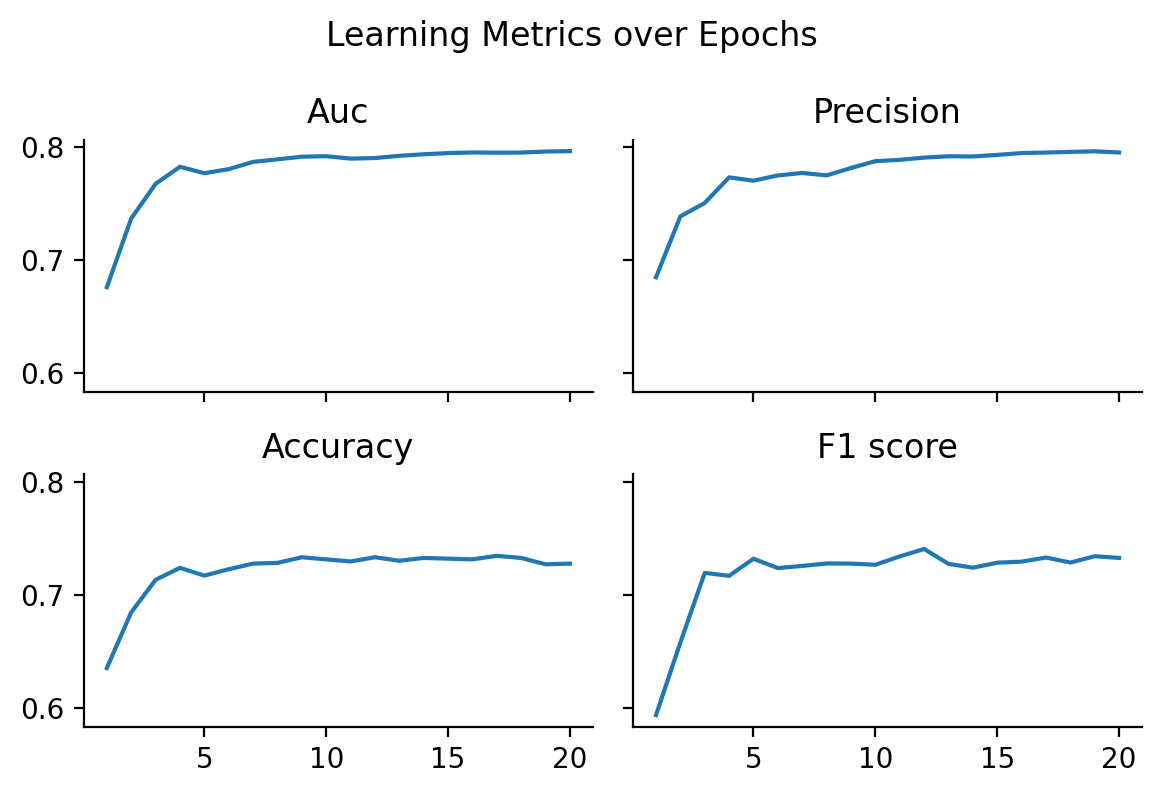

In [6]:
reload(ut)
sample_size = 2000
train_size = 0.6
emb_dim = 256
conv_dim = 128
order_threshold = 2
num_heads = 10
learning_rate = 0.001
# weight_decay = 5e-4
weight_decay = 0.01
max_epoch = 20

chroms = [
    '1',
]

res = []

for chrom in chroms:
    feature, I_train, y_train, I_test, y_test, Ipos, bins = prepare_trainning_data(pdf, 
                                                             chrom, 
                                                             order_threshold, 
                                                             sample_size, 
                                                             train_size)
    print(f"{feature.shape=}")
    print(f"{I_train.shape=}")
    print(f"{y_train.shape=}")
    print(f"{I_test.shape=}")
    print(f"{y_test.shape=}")
    print(f"{len(bins)=}")
    
    # build the model
    model = HyperSAGNN(input_dim=feature.shape, 
                       emb_dim=emb_dim, 
                       conv_dim=conv_dim,
                       num_heads=num_heads)

    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate, 
                                 weight_decay=weight_decay)

    for i in tqdm(range(max_epoch)):
        sag.train(feature, y_train, I_train, model, optimizer)
        auc, prc, acc, f1score = sag.test(feature, y_test, I_test, model)
        row = {
            'chrom' : chrom, 
            'epoch' : i+1, 
            'AUC' : auc, 
            'Precision' : prc, 
            'Accuracy' : acc, 
            'F1 Score' : f1score, 
        }
        res.append(row)

    break

res = pd.DataFrame(res)

max_metrics = res[['AUC', 'Precision', 'Accuracy', 'F1 Score']].max()
print(max_metrics)

reload(plt2)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4
plt2.plot_ml_metrics_over_epochs(res)

Text(0.5, 1.0, 'Non-Uniform Hyperedges')

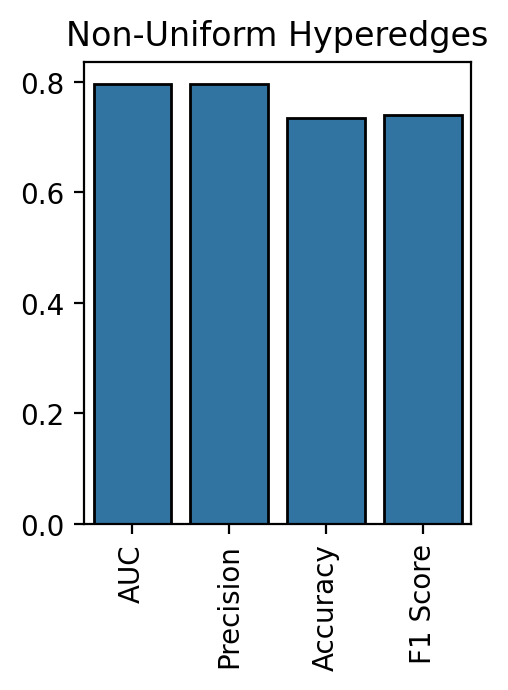

In [7]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2.5, 3

sns.barplot(max_metrics, ec='k')
plt.gca().tick_params(axis='x', rotation=90)
plt.title('Non-Uniform Hyperedges')

In [8]:
# break

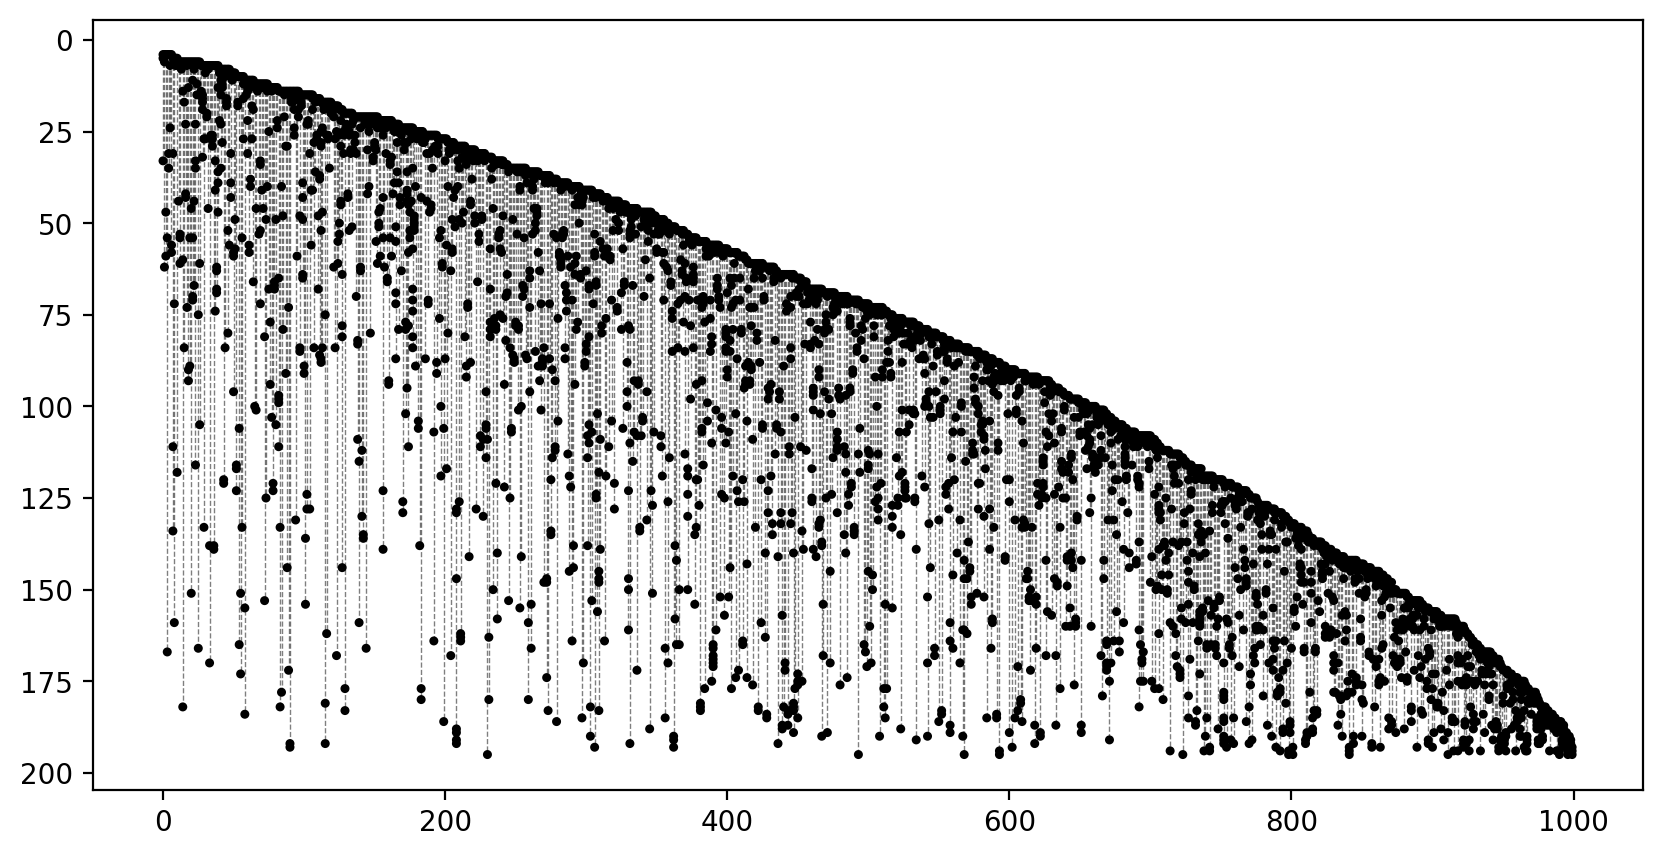

In [9]:
node_params = {
    's' : 5,
    'ec' : 'k',
    'lw' : 1,
    'zorder' : 2,
}

line_params = {
    'lw' : 0.5,
    'alpha' : 0.5,
    'zorder' : 1,
    'ls' : '--',
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 5
plt2.plot_incidence(ut.sort_by_lowest_index(Ipos.T.sample(1000).T), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

# Test a single-cell 

In [19]:
outpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/hypergraphs/sc_reconstruction.csv"
Isc = pd.read_csv(outpath)
Isc = Isc.rename(columns={'Unnamed: 0' : 'bin'})
Isc['bin'] = Isc['bin'] + 4.0
Isc = Isc.set_index('bin')
Isc.head()

,0,1,2,3,4,5,6,7,8,9,...,500,501,502,503,504,505,506,507,508,509
bin,,,,,,,,,,,,,,,,,,,,,
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7.0,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8.0,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


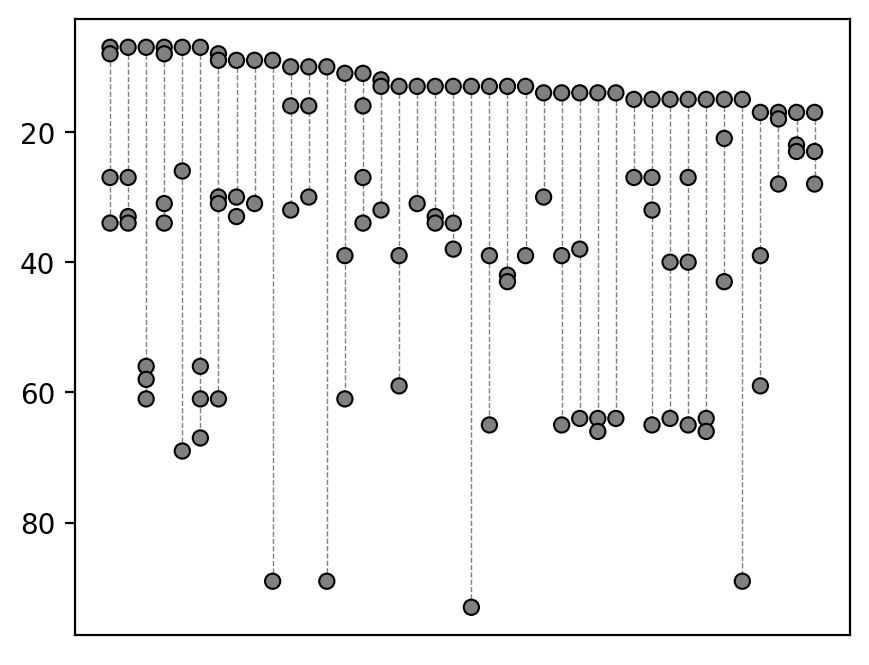

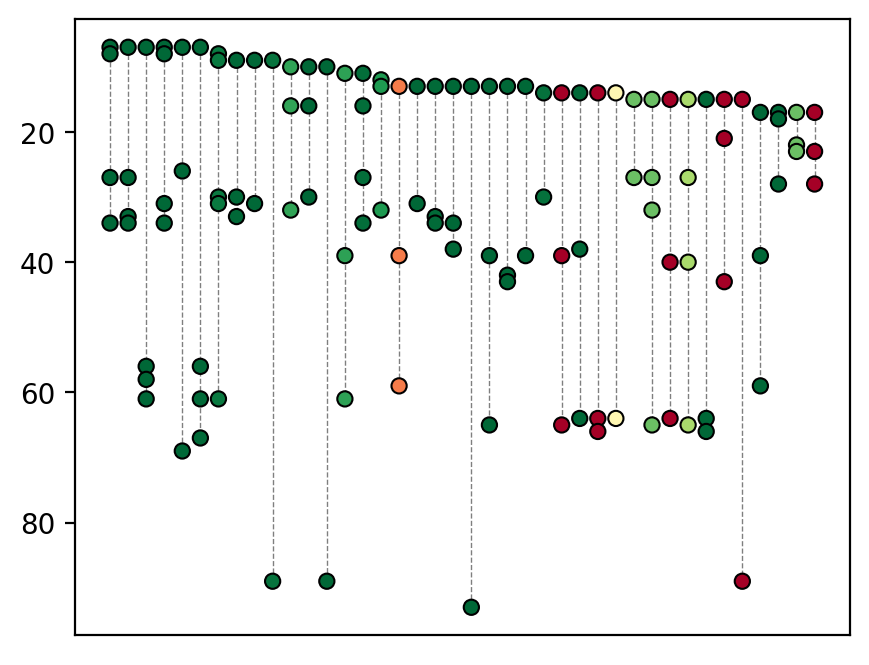

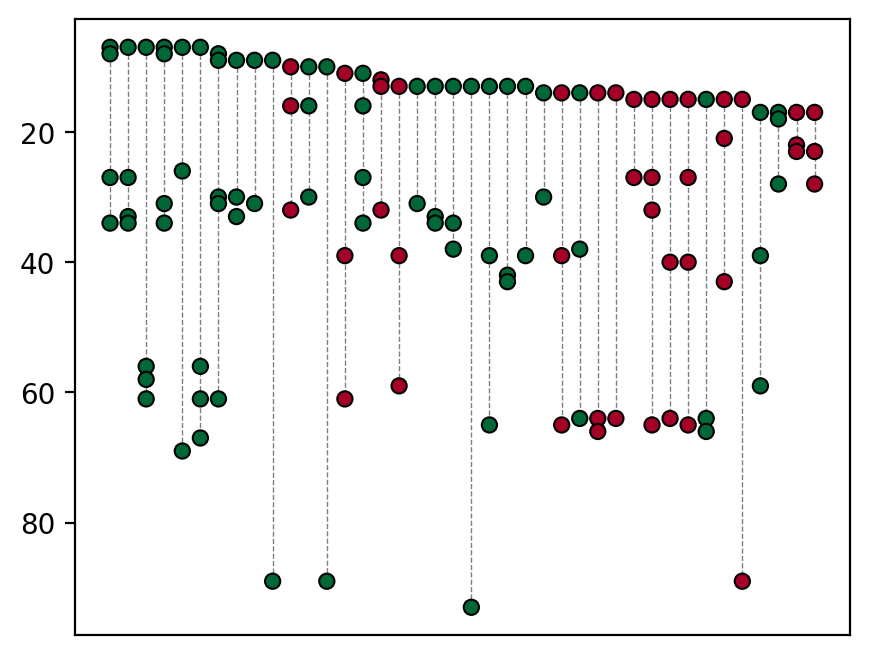

In [93]:
Isc_torch = torch.tensor(Isc.to_numpy(), dtype=torch.float)
y_pred = sag.predict(Isc_torch, model).detach().numpy().ravel()

node_params = {
    's' : 30,
    'ec' : 'k',
    'alpha' : 1.0,
    'lw' : 0.75,
    'zorder' : 2,
}

line_params = {
    'lw' : 0.5,
    'alpha' : 0.5,
    'zorder' : 1,
    'ls' : '--',
}


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4

n_hedges = 40

plt2.plot_incidence(ut.sort_by_lowest_index(Isc).iloc[:, : n_hedges], 
               node_color='grey',
               node_params=node_params,
               line_params=line_params)
plt.xticks([])
plt.show()

plt2.plot_incidence(ut.sort_by_lowest_index(Isc).iloc[:, : n_hedges], 
                    node_color=plt2.floats_to_colors(y_pred[:n_hedges],
                                                mode='colormap', 
                                                range_start=0.8, 
                                                range_end=1,
                                                colormap='RdYlGn'),
               node_params=node_params,
               line_params=line_params)
plt.xticks([])
plt.show()


# """FILTER THE RECONSTRUCTION """
t =  0.99
bin_color = np.where(y_pred > t, 1.0, 0)

plt2.plot_incidence(ut.sort_by_lowest_index(Isc).iloc[:, : n_hedges],
                    node_color=plt2.floats_to_colors(bin_color[:n_hedges],
                                                mode='colormap', 
                                                range_start=0.5, 
                                                range_end=1,
                                                colormap='RdYlGn'),
                    node_params=node_params,
                    line_params=line_params)
plt.xticks([])
plt.show()

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:

sample_size = 500
sample_idx = np.random.choice(range(I_test.shape[1]), sample_size, replace=False)

I_test_plot = pd.DataFrame(I_test.detach().numpy())

true_ind = np.argwhere(y_test[sample_idx] == 1).ravel().detach().numpy()
false_ind = np.argwhere(y_test[sample_idx] == 0).ravel().detach().numpy()

I_test_true = I_test_plot[I_test_plot.columns[true_ind]]
I_test_false = I_test_plot[I_test_plot.columns[~true_ind]]

print(f"{I_test_true.shape=}")
print(f"{I_test_false.shape=}")


node_params = {
    's' : 2,
    'ec' : 'k',
    'lw' : 0.1,
    'zorder' : 2,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 3
plt2.plot_incidence(ut.sort_by_lowest_index(I_test_true), 
               node_color='g',
               node_params=node_params,
               line_params=line_params)

plt.title('True Contacts')
plt.show()

node_params = {
    's' : 2,
    'ec' : 'k',
    'lw' : 0.1,
    'zorder' : 2,
}

plt2.plot_incidence(ut.sort_by_lowest_index(I_test_false), 
               node_color='r',
               node_params=node_params,
               line_params=line_params)

plt.title('False Contacts')
plt.show()

In [ ]:
reload(plt2)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 1.5

plt2.plot_incidence_order(I_test_true)
plt.title('True Contacts')
plt.show()
plt2.plot_incidence_order(I_test_false)
plt.title('False Contacts')
plt.show()

In [ ]:
A_true = ut.clique_expand_incidence(I_test_plot[I_test_plot.columns[true_ind]], 
                                    zero_diag=False)

A_false = ut.clique_expand_incidence(I_test_plot[I_test_plot.columns[false_ind]], 
                                    zero_diag=False)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].imshow(np.log1p(A_true))
axs[1].imshow(np.log1p(A_false))

axs[0].set_title('True Contacts')
axs[1].set_title('Random Contacts')

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()

In [ ]:
break

# Training on uniform hyperedges

In [ ]:
reload(ut)
sample_size = 5000
train_size = 0.6
emb_dim = 256
conv_dim = 128
order_threshold = 2
num_heads = 10
learning_rate = 0.001
# weight_decay = 5e-4
weight_decay = 0.01
max_epoch = 20

chrom = '1'
orders = [2, 3, 4, 5, 6, 7]

res = []

qdf = pdf.copy()
qdf = qdf[qdf['chrom'] == chrom]
qdf['order'] = qdf.groupby('read_name')['bin'].transform('nunique')


for order, group in qdf.groupby('order'):
    if not order in orders:
        continue

    feature, I_train, y_train, I_test, y_test, Ipos, bins = prepare_trainning_data(group, 
                                                             chrom, 
                                                             order_threshold-1, 
                                                             sample_size, 
                                                             train_size)
    print(f"{feature.shape=}")
    print(f"{I_train.shape=}")
    print(f"{y_train.shape=}")
    print(f"{I_test.shape=}")
    print(f"{y_test.shape=}")
    print(f"{len(bins)=}")
  
    # build the model
    model = HyperSAGNN(input_dim=feature.shape, 
                       emb_dim=emb_dim, 
                       conv_dim=conv_dim,
                       num_heads=num_heads)

    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate, 
                                 weight_decay=weight_decay)

    for i in tqdm(range(max_epoch)):
        sag.train(feature, y_train, I_train, model, optimizer)
        auc, prc, acc, f1score = sag.test(feature, y_test, I_test, model)
        row = {
            'order' : order, 
            'epoch' : i+1, 
            'AUC' : auc, 
            'Precision' : prc, 
            'Accuracy' : acc, 
            'F1 Score' : f1score, 
        }
        res.append(row)


res = pd.DataFrame(res)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.lineplot(data=res, 
             x='epoch',
             y='AUC',
             hue='order',
             palette='Set2')

plt.xlabel('Epoch')

sns.move_legend(plt.gca(),
                title='Order',
                loc='upper right',
                bbox_to_anchor=(1.4, 1))

# Train on 3-way interactions

In [ ]:
reload(ut)
sample_size = 1000
train_size = 0.6
emb_dim = 100
conv_dim = 50
order_threshold = 2
num_heads = 10
learning_rate = 0.001
weight_decay = 0.01
max_epoch = 20

chrom = '1'
order = 3

res = []

qdf = pdf.copy()
qdf = qdf[qdf['chrom'] == chrom]
qdf['order'] = qdf.groupby('read_name')['bin'].transform('nunique')
qdf = qdf[qdf['order'] == order]


feature, I_train, y_train, I_test, y_test, Ipos, bins = prepare_trainning_data(qdf, 
                                                         chrom, 
                                                         order_threshold-1, 
                                                         sample_size, 
                                                         train_size)
print(f"{feature.shape=}")
print(f"{I_train.shape=}")
print(f"{y_train.shape=}")
print(f"{I_test.shape=}")
print(f"{y_test.shape=}")
print(f"{len(bins)=}")

# build the model
model = HyperSAGNN(input_dim=feature.shape, 
                   emb_dim=emb_dim, 
                   conv_dim=conv_dim,
                   num_heads=num_heads)

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)

for i in tqdm(range(max_epoch)):
    sag.train(feature, y_train, I_train, model, optimizer)
    auc, prc, acc, f1score = sag.test(feature, y_test, I_test, model)
    row = {
        'order' : order, 
        'epoch' : i+1, 
        'AUC' : auc, 
        'Precision' : prc, 
        'Accuracy' : acc, 
        'F1 Score' : f1score, 
    }
    res.append(row)


res = pd.DataFrame(res)

max_metrics = res[['AUC', 'Precision', 'Accuracy', 'F1 Score']].max()
max_metrics

In [ ]:
linear_encoding = model.linear_encoder.state_dict()['weight'].detach().numpy()
Ahat = np.dot(linear_encoding.T, linear_encoding).astype(float)

plt.imshow(Ahat)

In [ ]:
# break

# denoise a single-cell using the trainned model

In [ ]:
reload(ut)

fpath = "/scratch/indikar_root/indikar1/shared_data/scpore_c/align_table/o1b41.GRCm39.align_table.parquet"
scdf = pd.read_parquet(fpath)
print(f"{scdf.shape=}")
scdf = scdf[scdf['near_unique'] & scdf['exact_unique']]
print(f"{scdf.shape=}")

sc_mapq = 1

print(f"Binning at {resolution_str} with mapq == {sc_mapq}")
scdf = filter_and_prepare_data(scdf, resolution, mapq=sc_mapq)
print(f"{scdf.shape=}")

for chrom in chroms:
    group = scdf[scdf['chrom'] == chrom].reset_index(drop=True)
    print(f"{group.shape=}")
    Isc, read_map = ut.process_chromosome_data(group, order_threshold, sample_size=10000)
    print(f"{Isc.shape=}")
    Isc = ut.fill_missing_bins(Isc, bins)
    print(f"{Isc.shape=}")
    Isc_torch = torch.tensor(Isc.to_numpy(), dtype=torch.float)
    y_pred = sag.predict(Isc_torch, model).detach().numpy().ravel()
    print(f"{y_pred.shape=}")

    pred_map = dict(zip(list(read_map.values()), y_pred))

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2

sns.histplot(y_pred, kde=True, bins=10)
plt.xlabel('P(x) = True')
sns.despine()

# Simple read-level stats

In [ ]:
def max_pairwise_distance(values):
    """Calculates the maximum pairwise distance using vectorized operations."""
    values_array = np.array(values)  # Convert to NumPy array

    # Create matrices by broadcasting 
    differences = np.subtract.outer(values_array, values_array) 
    # Maximum absolute difference along any axis represents the maximum pairwise distance
    return np.abs(differences).max()

def mean_pairwise_distance(values):
    """Calculates the maximum pairwise distance using vectorized operations."""
    values_array = np.array(values)  # Convert to NumPy array

    # Create matrices by broadcasting 
    differences = np.subtract.outer(values_array, values_array) 
    # Maximum absolute difference along any axis represents the maximum pairwise distance
    return np.abs(differences).mean()

# get the reads which we made predictions for
pred = group[group['read_name'].isin(read_map.values())]

# aggregate read-level statistics
pred = pred.groupby('read_name').agg(
    mean_mapq = ('mapping_quality', 'mean'),
    # min_mapq = ('mapping_quality', 'min'),
    order = ('bin', 'nunique'),
    # len_on_read = ('length_on_read', 'mean'),
    # max_bin_dist = ('bin', max_pairwise_distance),
    mean_bin_dist = ('bin', mean_pairwise_distance),
).reset_index()

pred['y_pred'] = pred['read_name'].map(pred_map)
pred = pred.set_index('read_name')

target_column = 'y_pred'

for column in pred.columns:
    if column != target_column:
        r, pval = scipy.stats.pearsonr(pred[column], pred[target_column])
        print(f"{column} {r=:.2f} {pval=:.5f}")

In [ ]:
sns.pairplot(data=pred, 
             kind="kde",
             y_vars='y_pred')

In [ ]:
# break

In [ ]:
node_params = {
    's' : 30,
    'ec' : 'k',
    'lw' : 1,
    'zorder' : 2,
}

line_params = {
    'lw' : 0.5,
    'alpha' : 0.5,
    'zorder' : 1,
    'ls' : '--',
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4
plot_incidence(ut.sort_by_lowest_index(Isc), 
               node_color=floats_to_colors(y_pred, mode='colormap', colormap='RdYlGn'),
               node_params=node_params,
               line_params=line_params)

In [ ]:
break

# combine and plot

In [ ]:
def merge_incidence(incidence_matrices):
    """Merges copies of incidence matrices, adding unique prefixes to column names.

    Args:
        incidence_matrices (list of pd.DataFrame): A list of incidence matrices to be merged.

    Returns:
        pd.DataFrame: The merged incidence matrix with disambiguated column names (original matrices are unmodified).
    """
    matrices_with_prefix = []  # Store modified copies

    for i, matrix in enumerate(incidence_matrices):
        matrix_copy = matrix.copy()  # Create a copy 
        prefix = f"{i}_"
        matrix_copy.columns = [f"{prefix}{col}" for col in matrix_copy.columns]  
        matrices_with_prefix.append(matrix_copy) 

    return pd.concat(matrices_with_prefix, axis=1)


I = merge_incidence([Isc, I_train])
I = ut.sort_by_lowest_index(I)
colors = [int(x.split("_")[0]) for x in I.columns]
colors = ['grey' if x == 1 else 'r' for x in colors]

node_params = {
    's' : 5,
    'ec' : 'k',
    'lw' : 0.1,
    'zorder' : 2,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 5

plot_incidence(I, 
               node_color=colors,
               node_params=node_params,
               line_params=line_params)


In [ ]:
break

In [ ]:
y_pred

In [ ]:
plot_incidence(sort_by_lowest_index(Ipos), 
               node_params=node_params,
               line_params=line_params)

In [ ]:
break

In [ ]:

for chrom in chroms:
    print(chrom)
    break

In [ ]:
Isc

In [ ]:
group.columns

In [ ]:
gx = group.groupby('read_name').agg(
    mean_mapq = ('mapping_quality', 'mean'),
    min_mapq = ('mapping_quality', 'min'),
    order = ('align_id', 'count'),
).reset_index()

gx['pred'] = gx['read_name'].map(pred_map)
gx = gx[gx['pred'].notna()]

sns.scatterplot(data=gx,
                x='pred',
                y='mean_mapq')

In [ ]:
break

# plot them both

In [ ]:
break

In [ ]:
group.head()

In [ ]:
gx = group.groupby('read_name').agg(
    mean_mapq = ('mapping_quality', 'mean'),
    min_mapq = ('mapping_quality', 'min'),
    order = ('align_id', 'count'),
).reset_index()

gx['pred'] = gx['read_name'].map(pred_map)
gx = gx[gx['pred'].notna()]

sns.scatterplot(data=gx,
                x='pred',
                y='order')

In [ ]:
break

In [ ]:

        
for chrom in chroms:
    group = scdf[scdf['chrom'] == chrom].reset_index(drop=True)
    Isc = ut.process_chromosome_data(group, order_threshold, sample_size=10000)
    
    print(f"{Isc.shape=}")
    # Isc = ut.fill_missing_bins_from(Isc, bins)
    # Isc = torch.tensor(Isc.to_numpy(), dtype=torch.float)
    # y_pred = sag.predict(Isc, model)
    # print(f"{y_pred.shape=}")
    
    

In [ ]:
def predict(incidence_matrix, model):
    """Infers predictions from the model.

    Args:
        incidence_matrix (torch.Tensor): Hypergraph incidence matrix.
        model (torch.nn.Module): The PyTorch model.

    Returns:
        torch.Tensor: The predicted scores or probabilities.
    """
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        predictions = model(incidence_matrix, incidence_matrix) 
        return predictions 
        
y_pred = predict(Isc, model)
# y_pred.shape

In [ ]:
feature.shape

In [ ]:
reload(ut)

ut.fill_missing_bins_from(Isc, bins)